## Importing and loading the file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from scipy.optimize import linprog
from collections import Counter
import itertools


# Load the dataset with the `low_memory=False` option to prevent the warning
data = pd.read_csv('consumption_user.csv', low_memory=False)

# Display the first few rows of the dataset
print(data.head())

# Check the data types and null values to identify mixed-type columns
print(data.info())



   SUBJECT  ROUND  SURVEY_DAY  RESPONDER                    SEASON  \
0        1      1           1        NaN  harvest/winter (Nov-Feb)   
1        1      1           1        NaN  harvest/winter (Nov-Feb)   
2        1      1           1        NaN  harvest/winter (Nov-Feb)   
3        1      1           1        NaN  harvest/winter (Nov-Feb)   
4        1      1           1        NaN  harvest/winter (Nov-Feb)   

   CONSUMPTION_DAY  CONSUMPTION_MONTH  CONSUMPTION_YEAR  WEEK_DAY  \
0              NaN                 10              2014       NaN   
1              NaN                 10              2014       NaN   
2              NaN                 10              2014       NaN   
3              NaN                 10              2014       NaN   
4              NaN                 10              2014       NaN   

   EXCEPTION_DAY  ...  VITA_RE_mcg  BCAROT_mcg  RETOL_mcg  VITD_mcg  VITE_mg  \
0            NaN  ...          NaN         NaN        NaN       NaN      NaN   
1   

## Dropping the null values 

In [3]:
# Step 1: Drop columns with more than 90% missing values
threshold = 0.9
columns_to_drop = data.columns[data.isnull().mean() > threshold]
data_cleaned = data.drop(columns=columns_to_drop)

# Step 2: Handle mixed-type columns
# Convert the VERSION column to string if it exists
if 'VERSION' in data_cleaned.columns:
    data_cleaned['VERSION'] = data_cleaned['VERSION'].astype(str)

# Step 3: Review remaining null values
null_summary = data_cleaned.isnull().sum()
print("Remaining Null Values Per Column:")
print(null_summary[null_summary > 0])

# Step 4: Save the cleaned dataset (optional)
data_cleaned.to_csv('cleaned_consumption_user.csv', index=False)

# Step 5: Display the cleaned dataset information
print("Cleaned Dataset Info:")
data_cleaned.info()


Remaining Null Values Per Column:
RECIPE_CODE         1416
RECIPE_DESCR_ENG    1416
AMOUNT_RECIPE       1416
dtype: int64
Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34677 entries, 0 to 34676
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SUBJECT               34677 non-null  int64  
 1   ROUND                 34677 non-null  int64  
 2   SURVEY_DAY            34677 non-null  int64  
 3   SEASON                34677 non-null  object 
 4   CONSUMPTION_MONTH     34677 non-null  int64  
 5   CONSUMPTION_YEAR      34677 non-null  int64  
 6   MEAL_NAME             34677 non-null  int64  
 7   FOOD_TYPE             34677 non-null  int64  
 8   RECIPE_CODE           33261 non-null  float64
 9   RECIPE_DESCR_ENG      33261 non-null  object 
 10  AMOUNT_RECIPE         33261 non-null  float64
 11  CODE_INGREDIENT       34677 non-null  int64  
 12  INGREDIENT_ENG        34677 

## Converting Nan values to its names

In [5]:

# Replace NaN values with default names or inferred values
# Example 1: Replace all NaN with a placeholder value
data_filled = data.fillna('Unknown')

# Example 2: Replace NaN in specific columns with placeholders or custom values
columns_to_replace = ['RECIPE_DESCR_ENG', 'INGREDIENT_ENG']  # Update with your column names
for col in columns_to_replace:
    if col in data.columns:
        data[col] = data[col].fillna(f"Missing {col}")  # Replace NaN with 'Missing <column_name>'

# Example 3: Replace NaN in specific columns with values from another column
if 'RECIPE_CODE' in data.columns and 'RECIPE_DESCR_ENG' in data.columns:
    data['RECIPE_DESCR_ENG'] = data['RECIPE_DESCR_ENG'].fillna(data['RECIPE_CODE'].astype(str))

# Save the updated dataset
output_path = 'replaced_nan_values.csv'  # Update the filename if needed
data.to_csv(output_path, index=False)

# Display a message for success
print(f"NaN values replaced and the updated dataset is saved to {output_path}")
print(data.head())

NaN values replaced and the updated dataset is saved to replaced_nan_values.csv
   SUBJECT  ROUND  SURVEY_DAY  RESPONDER                    SEASON  \
0        1      1           1        NaN  harvest/winter (Nov-Feb)   
1        1      1           1        NaN  harvest/winter (Nov-Feb)   
2        1      1           1        NaN  harvest/winter (Nov-Feb)   
3        1      1           1        NaN  harvest/winter (Nov-Feb)   
4        1      1           1        NaN  harvest/winter (Nov-Feb)   

   CONSUMPTION_DAY  CONSUMPTION_MONTH  CONSUMPTION_YEAR  WEEK_DAY  \
0              NaN                 10              2014       NaN   
1              NaN                 10              2014       NaN   
2              NaN                 10              2014       NaN   
3              NaN                 10              2014       NaN   
4              NaN                 10              2014       NaN   

   EXCEPTION_DAY  ...  VITA_RE_mcg  BCAROT_mcg  RETOL_mcg  VITD_mcg  VITE_mg  \
0   

## 1. NUTRITIONAL ANALYSIS AND OPTIMISATION FOR PUBLIC HEALTH

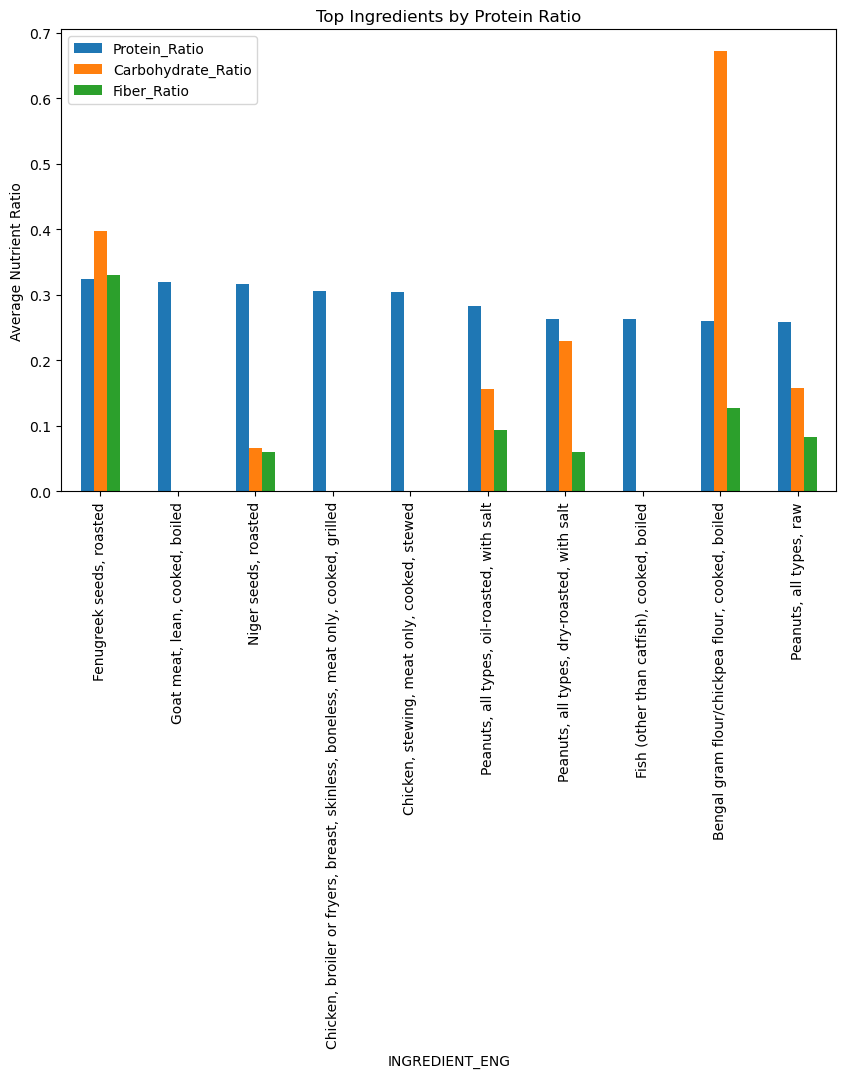

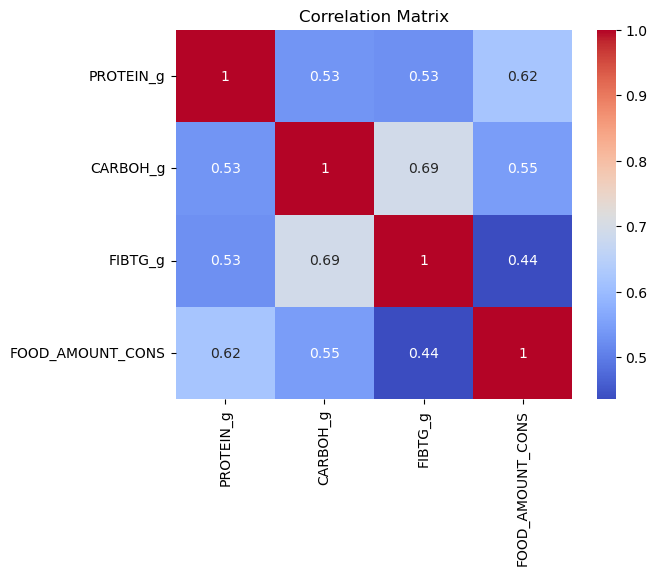

Mean Squared Error: 20.30
R-squared: 0.96


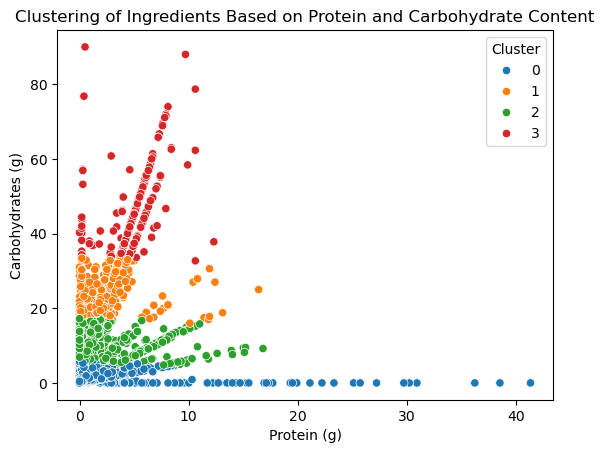

         PROTEIN_g   CARBOH_g   FIBTG_g
Cluster                                
0         0.218215   0.483024  0.107408
1         2.530444  23.155285  1.622199
2         1.412344  10.791508  0.562113
3         4.554699  43.955422  2.966747


In [9]:

food_data = pd.read_csv('Food.csv')
# Preprocessing: Handle missing values
food_data = food_data[['INGREDIENT_ENG', 'PROTEIN_g', 'CARBOH_g', 'FIBTG_g', 'FOOD_AMOUNT_CONS']].copy()
food_data.fillna(0, inplace=True)

# Descriptive Analysis
# 1. Compute nutrient-to-food ratios
food_data['Protein_Ratio'] = food_data['PROTEIN_g'] / food_data['FOOD_AMOUNT_CONS']
food_data['Carbohydrate_Ratio'] = food_data['CARBOH_g'] / food_data['FOOD_AMOUNT_CONS']
food_data['Fiber_Ratio'] = food_data['FIBTG_g'] / food_data['FOOD_AMOUNT_CONS']

# 2. Aggregate by ingredient and analyze averages
ingredient_summary = food_data.groupby('INGREDIENT_ENG').mean()
ingredient_summary = ingredient_summary[['Protein_Ratio', 'Carbohydrate_Ratio', 'Fiber_Ratio']]

# Plot nutrient ratios for top ingredients
top_ingredients = ingredient_summary.sort_values(by='Protein_Ratio', ascending=False).head(10)
top_ingredients.plot(kind='bar', figsize=(10, 6), title="Top Ingredients by Protein Ratio")
plt.ylabel("Average Nutrient Ratio")
plt.show()

# 3. Correlation analysis
correlation_matrix = food_data[['PROTEIN_g', 'CARBOH_g', 'FIBTG_g', 'FOOD_AMOUNT_CONS']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Predictive Analysis
# Define features (X) and target variable (y)
X = food_data[['PROTEIN_g', 'CARBOH_g', 'FIBTG_g']]
y = food_data['FOOD_AMOUNT_CONS']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Regressor
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Clustering Analysis
# Apply clustering to nutrient columns
nutrient_data = food_data[['PROTEIN_g', 'CARBOH_g', 'FIBTG_g']]
kmeans = KMeans(n_clusters=4, random_state=42)
food_data['Cluster'] = kmeans.fit_predict(nutrient_data)

# Visualize clusters
sns.scatterplot(data=food_data, x='PROTEIN_g', y='CARBOH_g', hue='Cluster', palette='tab10')
plt.title("Clustering of Ingredients Based on Protein and Carbohydrate Content")
plt.xlabel("Protein (g)")
plt.ylabel("Carbohydrates (g)")
plt.show()

# Display summary of clusters
cluster_summary = food_data.groupby('Cluster')[['PROTEIN_g', 'CARBOH_g', 'FIBTG_g']].mean()
print(cluster_summary)


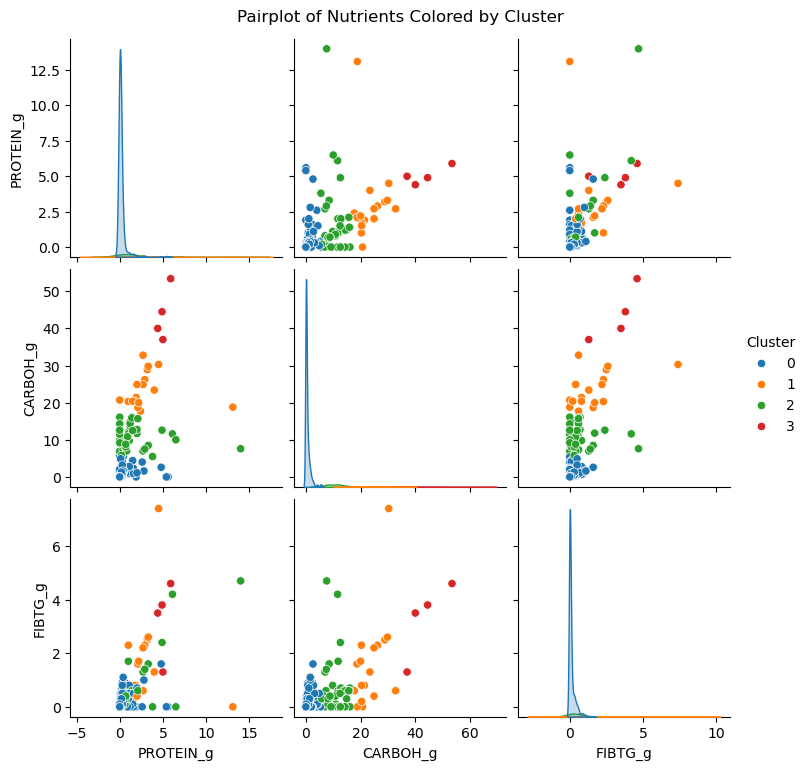

In [11]:
# Additional Visualization: Pairplot of Nutrients by Ingredient



# Sample a subset of the data for clarity (optional)
sampled_data = food_data.sample(n=500, random_state=42)

# Create a pairplot of the nutrient variables colored by cluster
sns.pairplot(sampled_data, vars=['PROTEIN_g', 'CARBOH_g', 'FIBTG_g'], hue='Cluster', palette='tab10', diag_kind='kde')
plt.suptitle('Pairplot of Nutrients Colored by Cluster', y=1.02)
plt.show()


## 2. FREQUENCY ANALYSIS APPROACH TO INGREDIENT PAIRINGS AND NUTRIENT PATTERNS

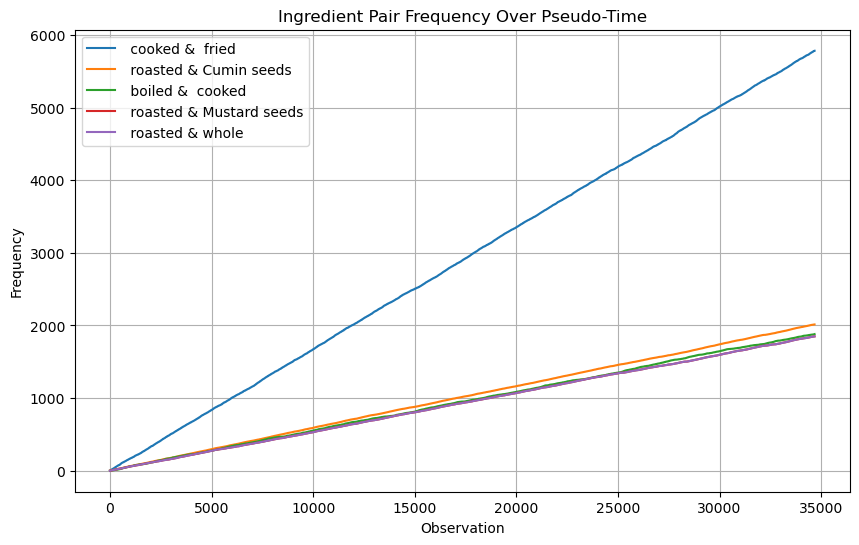

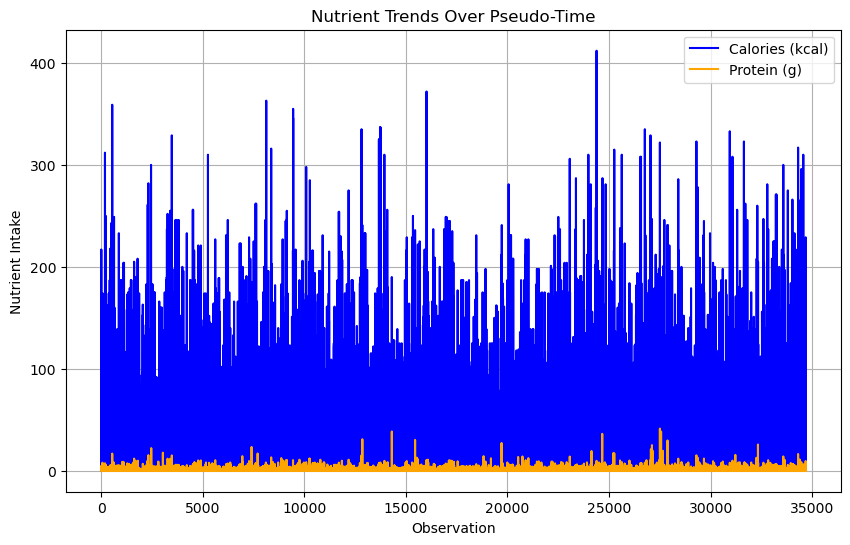

In [14]:
# Step 1: Preprocessing
# Load dataset
file_path = 'Food.csv'  # Replace with actual file path
food_data = pd.read_csv('Food.csv')
# Add Observation index for pseudo-time
food_data['Observation'] = range(1, len(food_data) + 1)

# Fill missing values in ingredients column
food_data['INGREDIENT_ENG'] = food_data['INGREDIENT_ENG'].fillna('')

# Extract ingredient pairs
def extract_pairs(ingredients):
    items = ingredients.split(',')  # Assuming ingredients are comma-separated
    return list(itertools.combinations(sorted(set(items)), 2))

food_data['Ingredient_Pairs'] = food_data['INGREDIENT_ENG'].apply(lambda x: extract_pairs(x) if x.strip() else [])

# Step 2: Track Ingredient Pair Trends
pair_counter = Counter()
pair_trends = []

for _, row in food_data.iterrows():
    pairs = row['Ingredient_Pairs']
    pair_counter.update(pairs)
    # Record top pairs at each observation
    pair_trends.append(pair_counter.copy())

# Convert trends to DataFrame
top_pairs = [pair for pair, _ in pair_counter.most_common(5)]  # Top 5 ingredient pairs
pair_trends_df = pd.DataFrame([{pair: counts.get(pair, 0) for pair in top_pairs} for counts in pair_trends])

# Step 3: Nutrient Trends Over Time
nutrient_trends = food_data[['Observation', 'ENERGY_kcal', 'PROTEIN_g']].copy()

# Step 4: Visualization
# Ingredient Pair Trends
plt.figure(figsize=(10, 6))
for pair in top_pairs:
    plt.plot(pair_trends_df.index, pair_trends_df[pair], label=f'{pair[0]} & {pair[1]}')
plt.title('Ingredient Pair Frequency Over Pseudo-Time')
plt.xlabel('Observation')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

# Nutrient Trends
plt.figure(figsize=(10, 6))
plt.plot(nutrient_trends['Observation'], nutrient_trends['ENERGY_kcal'], label='Calories (kcal)', color='blue')
plt.plot(nutrient_trends['Observation'], nutrient_trends['PROTEIN_g'], label='Protein (g)', color='orange')
plt.title('Nutrient Trends Over Pseudo-Time')
plt.xlabel('Observation')
plt.ylabel('Nutrient Intake')
plt.legend()
plt.grid()
plt.show()

## 3.	A DESCRIPTIVE ANALYSIS FOR SUSTAINABLE INSIGHTS

In [16]:
# Descriptive Statistics for Food Amount and Nutritional Information
descriptive_stats = data[['FOOD_AMOUNT_CONS', 'FOOD_AMOUNT_REPORTED', 'ENERGY_kcal', 'PROTEIN_g', 'FAT_g']].describe()

# Seasonal Analysis: Total consumption across seasons
seasonal_consumption = data.groupby('SEASON')[['FOOD_AMOUNT_CONS']].sum().sort_values(by='FOOD_AMOUNT_CONS', ascending=False)

# Meal-Level Analysis: Average consumption and reported amount per meal
meal_analysis = data.groupby('MEAL_NAME')[['FOOD_AMOUNT_CONS', 'FOOD_AMOUNT_REPORTED']].mean()

# Calculate food waste: Difference between reported and consumed amounts
data['FOOD_WASTE'] = data['FOOD_AMOUNT_REPORTED'] - data['FOOD_AMOUNT_CONS']

# Top Ingredients with Highest Food Waste
high_waste_ingredients = (
    data.groupby('FOODEX2_INGR_DESCR')[['FOOD_WASTE']]
    .mean()
    .sort_values(by='FOOD_WASTE', ascending=False)
    .head(10)
)

# Display results
print("Descriptive Statistics for Nutritional Data:")
print(descriptive_stats)

print("\nSeasonal Consumption Analysis:")
print(seasonal_consumption)

print("\nMeal-Level Consumption Analysis:")
print(meal_analysis)

print("\nTop Ingredients with High Food Waste:")
print(high_waste_ingredients)


Descriptive Statistics for Nutritional Data:
       FOOD_AMOUNT_CONS  FOOD_AMOUNT_REPORTED   ENERGY_kcal     PROTEIN_g  \
count      34677.000000          34677.000000  34677.000000  34677.000000   
mean           9.954713              9.954713     18.203997      0.437806   
std           23.337208             23.337208     36.539865      1.283140   
min            0.000000              0.000000      0.000000      0.000000   
25%            0.300000              0.300000      0.000000      0.000000   
50%            1.300000              1.300000      2.000000      0.000000   
75%            8.200000              8.200000     20.000000      0.200000   
max          511.000000            511.000000    412.000000     41.300000   

              FAT_g  
count  34677.000000  
mean       0.738230  
std        2.092471  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.200000  
max       40.200000  

Seasonal Consumption Analysis:
                              F

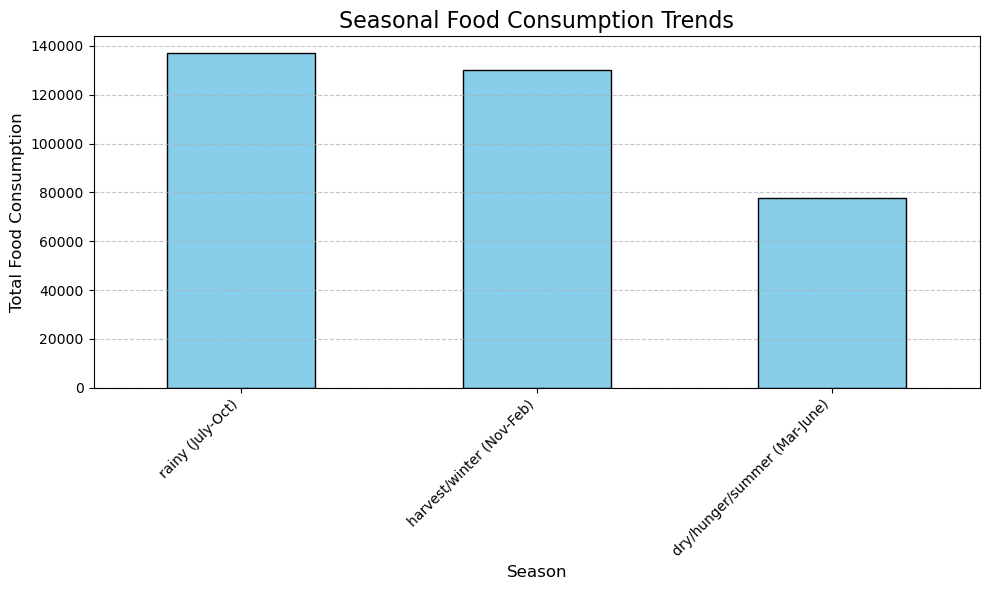

In [18]:
# Prepare data for plotting
seasonal_data = data.groupby('SEASON')['FOOD_AMOUNT_CONS'].sum().sort_values(ascending=False)

# Create the bar chart
plt.figure(figsize=(10, 6))
seasonal_data.plot(kind='bar', color='skyblue', edgecolor='black')

# Add titles and labels
plt.title('Seasonal Food Consumption Trends', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Total Food Consumption', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


 ## 4.	CORRELATION BETWEEN PROTEIN AND CARBOHYDRATES 

['SUBJECT', 'ROUND', 'SURVEY_DAY', 'RESPONDER', 'SEASON', 'CONSUMPTION_DAY', 'CONSUMPTION_MONTH', 'CONSUMPTION_YEAR', 'WEEK_DAY', 'EXCEPTION_DAY', 'CONSUMPTION_TIME_HOUR', 'CONSUMPTION_TIME_MINUTES', 'MEAL_NAME', 'PLACE', 'FOOD_TYPE', 'RECIPE_CODE', 'RECIPE_DESCR', 'RECIPE_DESCR_ENG', 'FOODEX2_RECIPE_CODE', 'FOODEX2_RECIPE_DESCR', 'AMOUNT_RECIPE', 'CODE_INGREDIENT', 'INGREDIENT', 'INGREDIENT_ENG', 'FOODEX2_INGR_CODE', 'FOODEX2_INGR_DESCR', 'FOOD_AMOUNT_UNPROC', 'FOOD_AMOUNT_CONS', 'FOOD_AMOUNT_REPORTED', 'ENERGY_kcal', 'WATER_g', 'PROTEIN_g', 'A_PROT_g', 'V_PROT_g', 'CARBOH_g', 'SUGAR_g', 'FIBTG_g', 'ALCOHOL_g', 'FAT_g', 'SAT_FAT_g', 'MUFA_g', 'PUFA_g', 'TFA_g', 'CHOL_mg', 'CALC_mg', 'IRON_mg', 'ZINC_mg', 'MG_mg', 'PHOS_mg', 'POTA_mg', 'NA_mg', 'CU_mg', 'IOD_mcg', 'SE_mcg', 'MN_mg', 'VITC_mg', 'THIA_mg', 'RIBO_mg', 'NIAC_mg', 'VITB5_mg', 'VITB6_mg', 'FOLDFE_mcg', 'FOL_mcg', 'FOLFD_mcg', 'FOLFRE_mcg', 'FOLAC_mcg', 'VITB12_mcg', 'VITA_RAE_mcg', 'VITA_RE_mcg', 'BCAROT_mcg', 'RETOL_mcg', '

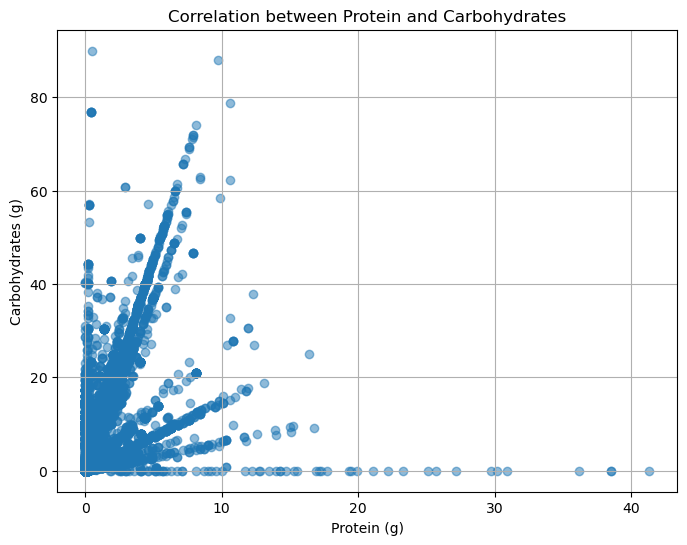

In [20]:
# Check the column names to ensure correct references
print(data.columns.tolist())

# Extract protein and carbohydrate data
protein_data = data['PROTEIN_g']  # Replace with the actual name if it differs
carboh_data = data['CARBOH_g']  # Replace with the actual name if it differs

# Plot the scatter plot to visualize the correlation
plt.figure(figsize=(8,6))
plt.scatter(protein_data, carboh_data, alpha=0.5)
plt.title('Correlation between Protein and Carbohydrates')
plt.xlabel('Protein (g)')
plt.ylabel('Carbohydrates (g)')
plt.grid(True)
plt.show()


## 5. Food Waste Analysis in Meal Consumption


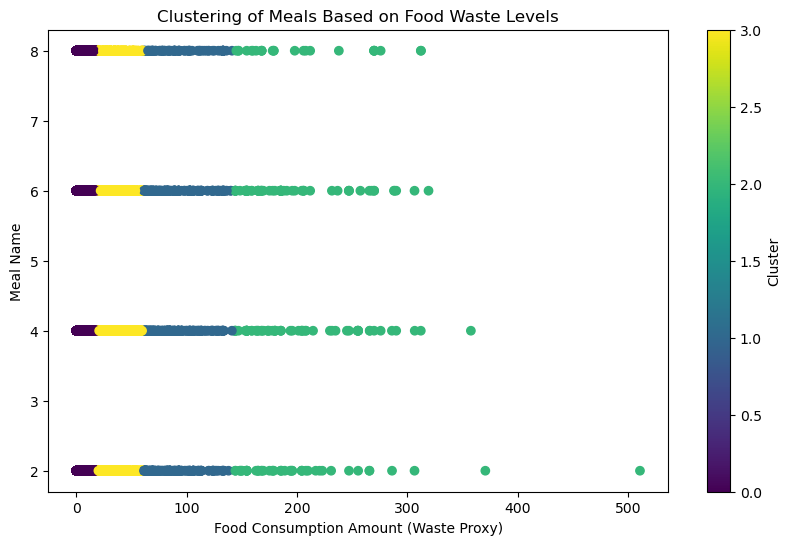

In [22]:
# Select relevant columns for clustering, for example FOOD_AMOUNT_CONS and MEAL_NAME
# We'll assume 'FOOD_AMOUNT_CONS' might indicate food consumption (waste proxy)
data_for_clustering = food_data[['FOOD_AMOUNT_CONS', 'MEAL_NAME']].dropna()

# Standardize the data before clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering[['FOOD_AMOUNT_CONS']])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # You can adjust the number of clusters
clusters = kmeans.fit_predict(scaled_data)

# Add the cluster labels to the original data
data_for_clustering['Cluster'] = clusters

# Visualizing the clusters
plt.figure(figsize=(10, 6))
plt.scatter(data_for_clustering['FOOD_AMOUNT_CONS'], data_for_clustering['MEAL_NAME'], c=data_for_clustering['Cluster'], cmap='viridis')
plt.title('Clustering of Meals Based on Food Waste Levels')
plt.xlabel('Food Consumption Amount (Waste Proxy)')
plt.ylabel('Meal Name')
plt.colorbar(label='Cluster')
plt.show()


## 6. Diagnostic Analysis 

In [24]:
# Enhanced Diagnostic Analysis
def enhanced_diagnostic_analysis(df):
    print("=== Enhanced Diagnostic Analysis ===")
   
    # 1. Meals and Seasons Analysis
    print("\n--- Meals and Seasons Analysis ---")
    print("Most Common Meals by Frequency:")
    print(df['MEAL_NAME'].value_counts().head())
    
    print("\nFood Consumption by Season:")
    season_counts = df['SEASON'].value_counts()
    print(season_counts)
    
    # 2. Nutritional Summary
    print("\n--- Nutritional Summary ---")
    nutrition_cols = ['ENERGY_kcal', 'PROTEIN_g', 'CARBOH_g', 'FAT_g']
    print("Nutritional Statistics:")
    print(df[nutrition_cols].describe())
    
    
    # 3. Entity-Specific Aggregates
    print("\n--- Entity-Specific Aggregates ---")
    
    # Meals and Average Nutritional Content
    meal_nutrition = df.groupby('MEAL_NAME')[nutrition_cols].mean().sort_values(by='ENERGY_kcal', ascending=False)
    print("\nTop 5 Meals by Average Calories:")
    print(meal_nutrition.head())
    
    # Ingredients with Highest Waste
    if 'FOODEX2_INGR_DESCR' in df.columns and 'FOOD_AMOUNT_CONS' in df.columns:
        ingredient_waste = df.groupby('FOODEX2_INGR_DESCR')['FOOD_AMOUNT_CONS'].mean().sort_values(ascending=True)
        print("\nIngredients with Lowest Average Consumption:")
        print(ingredient_waste.head())
    
    # Seasonal Trends in Energy
    seasonal_energy = df.groupby('SEASON')['ENERGY_kcal'].mean().sort_values(ascending=False)
    print("\nSeasonal Trends in Average Energy (kcal):")
    print(seasonal_energy)

    # 4. Correlation Analysis
    print("\n--- Correlation Analysis ---")
    numeric_cols = df.select_dtypes(include=[np.number])  # Select numeric columns
    correlations = numeric_cols.corr()
    print("Top Correlations Among Nutritional Variables:")
    print(correlations.loc[nutrition_cols, nutrition_cols].unstack().sort_values(ascending=False).drop_duplicates().head(10))

# Run the Enhanced Diagnostic Analysis
enhanced_diagnostic_analysis(data)


=== Enhanced Diagnostic Analysis ===

--- Meals and Seasons Analysis ---
Most Common Meals by Frequency:
MEAL_NAME
4    11241
2    10712
6     9539
8     3185
Name: count, dtype: int64

Food Consumption by Season:
SEASON
rainy (July-Oct)                13671
harvest/winter (Nov-Feb)        13301
dry/hunger/summer (Mar-June)     7705
Name: count, dtype: int64

--- Nutritional Summary ---
Nutritional Statistics:
        ENERGY_kcal     PROTEIN_g      CARBOH_g         FAT_g
count  34677.000000  34677.000000  34677.000000  34677.000000
mean      18.203997      0.437806      2.524901      0.738230
std       36.539865      1.283140      6.701018      2.092471
min        0.000000      0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000      0.000000
50%        2.000000      0.000000      0.100000      0.000000
75%       20.000000      0.200000      1.100000      0.200000
max      412.000000     41.300000     90.000000     40.200000

--- Entity-Specific Aggrega